In [18]:
%pip install spacy imblearn

import numpy as np
import spacy
import re
import nltk
import pickle
import json
import pandas as pd
from spacy.lang.nb import Norwegian
from nltk.corpus import stopwords
from sklearn.datasets import load_files
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.linear_model import SGDClassifier
from imblearn.over_sampling import BorderlineSMOTE

from wordcloud import WordCloud
from matplotlib import colors
import matplotlib.pyplot as plt


# nltk.download("stopwords")
# nltk.download("wordnet")

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: C:\Program Files\Python310\python.exe -m pip install --upgrade pip


In [26]:
!py -m spacy download nb_core_news_sm

Defaulting to user installation because normal site-packages is not writeable
     ---------------------------------------- 12.5/12.5 MB 6.7 MB/s eta 0:00:00
[+] Download and installation successful
You can now load the package via spacy.load('nb_core_news_sm')



[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: C:\Program Files\Python310\python.exe -m pip install --upgrade pip


In [27]:
data = {}
stops = stopwords.words('norwegian')
nlp = spacy.load('nb_core_news_sm')

# print(stops)

for name in ["train", "dev", "test"]:
    with open("{0}.json".format(name)) as infile:
        data[name] = json.load(infile)

In [28]:
train = pd.DataFrame.from_dict(data["train"])
test = pd.DataFrame.from_dict(data["test"])

X_train_raw = train['text']
y_train = train['label']

X_test_raw = test['text']
y_test = test['label']

# train
# test

In [29]:
stemmer = nlp.get_pipe('lemmatizer')

def lemmatize(X: list[str], n_to_print=0):
    documents = []
    for sen in range(0, len(X)):
        # Remove all the special characters
        document = re.sub(r'\W', ' ', str(X[sen]))

        if len(documents) < n_to_print:
            print('Original:', document)

        # remove all single characters
        document = re.sub(r'\s+[a-zA-ZæøåÆØÅ]\s+', ' ', document)

        # Remove single characters from the start
        document = re.sub(r'\^[a-zA-ZæøåÆØÅ]\s+', ' ', document)

        if len(documents) < n_to_print:
            print('Removed single characters:', document)

        # Substituting multiple spaces with single space
        document = re.sub(r'\s+', ' ', document, flags=re.I)

        # Removing prefixed 'b'
        # document = re.sub(r'^b\s+', '', document)

        # Converting to Lowercase
        document = document.lower()

        if len(documents) < n_to_print:
            print('Lowercase:', document)

        # Lemmatization
        document = nlp(document)

        document = [word.lemma_ for word in document]

        if len(documents) < n_to_print:
            print('Lemmatized:', document)
        document = ' '.join(document)

        documents.append(document)
    return documents


In [31]:
X_train_lemmas = lemmatize(X_train_raw, 2)
X_test_lemmas = lemmatize(X_test_raw)

vectorizer = TfidfVectorizer(stop_words=stops, ngram_range=(1,2))

X_train = vectorizer.fit_transform(X_train_lemmas).toarray()

# X_train

Original: Philips 190G6
Removed single characters: Philips 190G6
Lowercase: philips 190g6
Lemmatized: ['philips', '190g6']
Original: Med integrerte høyttalere som på ingen måte er diskret plassert   og med en stor subwoofer inkludert   da snakker vi om en gutteskjerm  
Removed single characters: Med integrerte høyttalere som på ingen måte er diskret plassert   og med en stor subwoofer inkludert   da snakker vi om en gutteskjerm  
Lowercase: med integrerte høyttalere som på ingen måte er diskret plassert og med en stor subwoofer inkludert da snakker vi om en gutteskjerm 
Lemmatized: ['med', 'integrert', 'høyttal', 'som', 'på', 'ingen', 'måte', 'være', 'diskre', 'plassere', 'og', 'med', 'en', 'stor', 'subwoof', 'inkludere', 'da', 'snakke', 'vi', 'om', 'en', 'gutteskjerm']


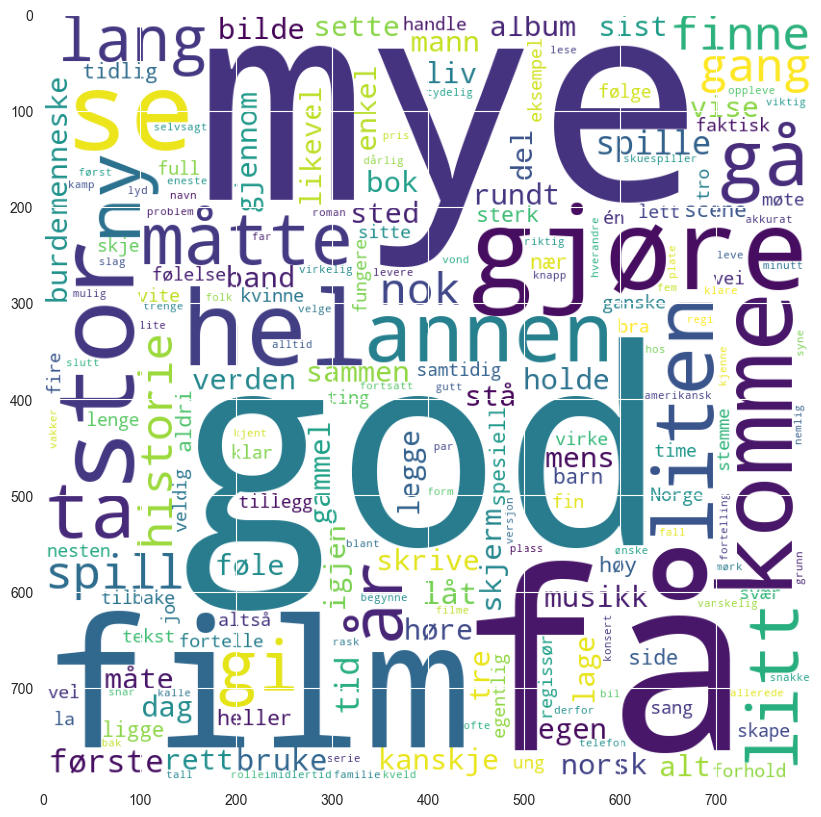

In [46]:
X_train_wc = []

for i in X_train_lemmas:
    for k in i.split():
        if k not in stops:
            X_train_wc.append(k)

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate((' '.join(X_train_wc)))

# print(X_train_wc)
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.tight_layout(pad = 0)

plt.show()

In [7]:
X_test = vectorizer.transform(X_test_lemmas).toarray()

X_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [8]:
classifier = SGDClassifier()
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

In [9]:
print(f'Non-rescaled: {accuracy_score(y_test, y_pred)}')

Non-rescaled: 0.6291278577476714


In [10]:
print(confusion_matrix(y_test, y_pred))

[[ 39  78  65]
 [ 29 446 123]
 [ 26 117 258]]


In [11]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    Negative       0.41      0.21      0.28       182
     Neutral       0.70      0.75      0.72       598
    Positive       0.58      0.64      0.61       401

    accuracy                           0.63      1181
   macro avg       0.56      0.53      0.54      1181
weighted avg       0.61      0.63      0.61      1181



In [12]:
resampler = BorderlineSMOTE(random_state=123)

X_train_res, y_train_res = resampler.fit_resample(X_train, y_train)

In [13]:
y_train_res.value_counts()

Neutral     4079
Negative    4079
Positive    4079
Name: label, dtype: int64

In [14]:
classifier_res = SGDClassifier()
classifier_res.fit(X_train_res, y_train_res)
y_pred_res = classifier_res.predict(X_test)

In [18]:
print(f'Rescaled: {accuracy_score(y_test, y_pred_res)}')

Rescaled: 0.6079593564775614


In [16]:
print(confusion_matrix(y_test, y_pred_res))

[[ 44  80  58]
 [ 55 434 109]
 [ 33 128 240]]


In [17]:
print(classification_report(y_test, y_pred_res))

              precision    recall  f1-score   support

    Negative       0.33      0.24      0.28       182
     Neutral       0.68      0.73      0.70       598
    Positive       0.59      0.60      0.59       401

    accuracy                           0.61      1181
   macro avg       0.53      0.52      0.52      1181
weighted avg       0.59      0.61      0.60      1181

